In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [44]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = nn.BatchNorm3d(in_channels) if batch_norm else None

        self.conv = nn.Sequential(                                                          # B I   H   L   W
            nn.Conv3d(in_channels, out_channels, 3, 1, padding=1),                          # B O   H   L   W
            nn.LeakyReLU(0.2),
            nn.Conv3d(out_channels, out_channels, (3, 2, 2), (1, 2, 2), padding=(1, 0, 0)), # B O   H   L/2 W/2
            nn.LeakyReLU(0.2),
            nn.Dropout3d(0.2, inplace=True)
        )
    
    def forward(self, x):
        # x     B   I   H   L   W

        x = self.batch_norm(x) if self.batch_norm else x    # B I   H   L   W
        out = self.conv(x)                                  # B O   H   L/2 W/2

        return out

In [45]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, batch_norms=(False, True)):
        super().__init__()

        if len(channels) != 3:
            raise Exception('You should pass 3 channels as in, hidden and out channels')

        if len(batch_norms) != 2:
            raise Exception('You should pass 2 batch_norms for 2 basic layers')

        self.conv = nn.Sequential(                                  # B I   H   L   W
            BasicBlock(channels[0], channels[1], batch_norms[0]),   # B M   H   L/2 W/2
            BasicBlock(channels[1], channels[2], batch_norms[1]),   # B O   H   L/4 W/4
        )

        self.downsample = nn.Sequential(                            # B I   H   L   W
            nn.Conv3d(channels[0], channels[2], 3, 1, padding=1),   # B O   H   L   W
            nn.LeakyReLU(0.2),
            nn.AvgPool3d((3, 4, 4), (1, 4, 4), padding=(1, 0, 0)),  # B O   H   L/4 W/4
        )
    
    def forward(self, x):
        # x     B   I   H   L   W

        out = self.conv(x)                  # B O   H   L/4 W/4
        downsampled = self.downsample(x)    # B O   H   L/4 W/4

        out += downsampled                  # B O   H   L/4 W/4

        return out

In [46]:
class MaskDiscriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(                          # B 3   H   256 256
            ResidualBlock((3, 4, 8), (False, True)),        # B 8   H   64  64
            ResidualBlock((8, 16, 32), (False, True)),      # B 32  H   16  16
            ResidualBlock((32, 64, 128), (False, True)),    # B 128 H   4   4
            ResidualBlock((128, 256, 512), (False, True)),  # B 512 H   1   1
        )

        # H B   512
        self.lstm = nn.LSTM(512, 256)                       # 1 B   256 + 1 B   256 =>  B   512

        self.decider = nn.Sequential(                       # B 512
            nn.Linear(512, 256),                            # B 256
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(256, 128),                            # B 128
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(128, 1),                              # B 1
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x     B   3   H   256  256

        x = self.conv(x)                # B 512 H   1   1
        x = x.squeeze(-1).squeeze(-1)   # B 512 H
        x = x.permute(2, 0, 1)          # H B   512
        _, (h, c) = self.lstm(x)        # 1 B   256 + 1 B   256
        out = torch.cat((h, c), dim=2)  # 1 B   512
        out = out.permute(1, 0, 2)      # B 1   512
        out = out.reshape(-1, 512)      # B 512
        out = self.decider(out)         # B 1
        out = out.flatten()             # B

        return out

In [5]:
def get_batches(X, y=None, batch_size=128, shuffle=True):
    if y is not None:
        assert X.shape[0] == y.shape[0]

    num_batches = int(np.ceil(X.shape[0] * 1.0 / batch_size))

    if shuffle:
        indices = np.random.permutation(X.shape[0])
        X = X[indices]
        if y is not None:
            y = y[indices]

    for batch in range(num_batches):
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X.shape[0])
        yield (batch, X[start:end], y[start:end]) if y is not None else (batch, X[start:end])

In [60]:
def train_discriminator(model, optimizer, X, y, batch_size):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()

    num_batches = int(np.ceil(X.shape[0] * 1.0 / batch_size))
    progress = tqdm(
        get_batches(X, y, batch_size=batch_size),
        position=0,
        leave=True,
        desc=f"Train",
        total=num_batches)
    
    for iter, b_X, b_y in progress:
        # b_X   B   2   H   64  64
        # b_y   B
        images = torch.tensor(b_X).cuda().float()
        target = torch.tensor(b_y).cuda().float()

        prediction = model(images)

        loss = F.binary_cross_entropy(prediction, target)
        decision = (prediction.detach().cpu().numpy() > 0.5)

        epoch_loss += float(loss)
        epoch_accuracy += (decision == b_y).sum()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        progress.set_postfix(
            loss=f"{epoch_loss / (iter + 1):.4e}",
            accuracy=f"{epoch_accuracy * 100. / ((iter + 1) * batch_size):.2f}"
        )

    epoch_loss /= iter + 1
    epoch_accuracy *= 100. / X.shape[0]

    progress.close()

    return epoch_loss, epoch_accuracy

In [61]:
def evaluate_discriminator(model, X, y, batch_size):
    epoch_loss = 0
    epoch_accuracy = 0

    num_batches = int(np.ceil(X.shape[0] * 1.0 / batch_size))
    progress = tqdm(
        get_batches(X, y, batch_size=batch_size, shuffle=False),
        position=0,
        leave=True,
        desc=f"Valid",
        total=num_batches)

    with torch.no_grad():
        model.eval()
        for iter, b_X, b_y in progress:
            images = torch.tensor(b_X).cuda().float()
            target = torch.tensor(b_y).cuda().float()

            prediction = model(images)

            loss = F.binary_cross_entropy(prediction, target)
            decision = (prediction.detach().cpu().numpy() > 0.5)

            epoch_loss += float(loss)
            epoch_accuracy += (decision == b_y).sum()

            progress.set_postfix(
                loss=f"{epoch_loss / (iter + 1):.4e}",
                accuracy=f"{epoch_accuracy * 100. / ((iter + 1) * batch_size):.2f}"
            )
        
    epoch_loss /= iter + 1
    epoch_accuracy *= 100. / X.shape[0]

    progress.close()
    
    return epoch_loss, epoch_accuracy

In [75]:
def read_dataset(root_path):
    xs = []
    for file in glob.glob(root_path + "/*.npy"):
        sample = torch.tensor(np.load(file))

        assert sample.ndim == 4
        assert sample.shape[-1] == 512
        assert sample.shape[-2] == 512

        sample = F.interpolate(sample.float(), 256, mode='bilinear')
        xs.append(sample)

    return np.array(xs)

In [30]:
X = np.random.uniform(size=(20, 3, 64, 256, 256)) > 0.5
y = np.random.uniform(size=20) > 0.5

In [31]:
# X = bone structure + left + right masks :) type: float
# y = label; type: bool

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((14, 3, 64, 256, 256), (4, 3, 64, 256, 256), (2, 3, 64, 256, 256)),
 ((14,), (4,), (2,)))

In [52]:
discriminator = MaskDiscriminator().cuda()
optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [64]:
batch_size = 1
epochs = 10

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

best_val_acc = 0

for e in range(epochs):

    print(f'\nEpoch {e+1}/{epochs}:', flush=True)

    epoch_train_loss, epoch_train_accuracy = train_discriminator(discriminator, optimizer, X_train, y_train, batch_size)
    epoch_val_loss, epoch_val_accuracy = evaluate_discriminator(discriminator, X_val, y_val, batch_size)

    if epoch_val_accuracy > best_val_acc:
        best_val_acc = epoch_val_accuracy
        torch.save(discriminator.state_dict(), 'drive/My Drive/mask-discriminator-model.pt')
    
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)   


Epoch 1/10:


Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.3121e-01]



Epoch 2/10:


Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.8692e-01]


Epoch 3/10:



Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.3553e-01]


Epoch 4/10:



Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.4650e-01]


Epoch 5/10:



Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.3422e-01]


Epoch 6/10:



Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.9632e-01]


Epoch 7/10:



Valid: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, accuracy=50.00, loss=7.2478e-01]


Epoch 8/10:



Train:  64%|██████▍   | 9/14 [00:22<00:13,  2.62s/it, accuracy=55.56, loss=7.0284e-01]

KeyboardInterrupt: ignored

In [8]:
import matplotlib.pylab as plt
import numpy as np
from skimage import io
from skimage import color
from skimage import segmentation

def draw_masked(images, masks, columns=4):
    assert images.shape == masks.shape
    
    rows = int(np.ceil(images.shape[0] / columns))
    max_size = 20
    
    width = min(columns * 5, max_size)
    height = width * rows // columns

    fig = plt.figure(figsize=(width, height))
    # plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
        
    for i in range(images.shape[0]):
        ax = fig.add_subplot(rows,columns,i+1)
        ax.imshow(color.label2rgb(masks[i],images[i], alpha=0.2, bg_label=0), origin='lower', cmap='gray')
        plt.axis('off')
    
    plt.show()

In [9]:
def draw(images, columns=4):
    rows = int(np.ceil(images.shape[0] / columns))
    max_size = 20
    
    width = max(columns * 5, max_size)
    height = width * rows // columns

    plt.figure(figsize=(width, height))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.01,0.01)
    for i in range(images.shape[0]):
        plt.subplot(rows,columns,i+1)
        plt.title(str(i))
        plt.imshow(images[i])
        plt.axis('off')
        # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
    plt.show()

In [10]:
import numpy as np

In [11]:
data = np.load('drive/My Drive/mask_sample/sample.npy')
data.shape, data.dtype

((3, 42, 512, 512), dtype('bool'))

In [46]:
x = torch.tensor(data[np.newaxis], dtype=torch.float32).cuda()
x.shape

torch.Size([1, 3, 42, 512, 512])

In [47]:
x = F.interpolate(x.float().reshape(3, -1, 512,512), (128, 128), mode='bilinear').reshape(1, 3, -1, 128, 128)
x.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 3, 42, 128, 128])

In [ ]:
m = MaskDiscriminator().cuda()

In [ ]:
m(x).shape

torch.Size([1])

In [48]:
mydata = x[0].cpu().numpy()

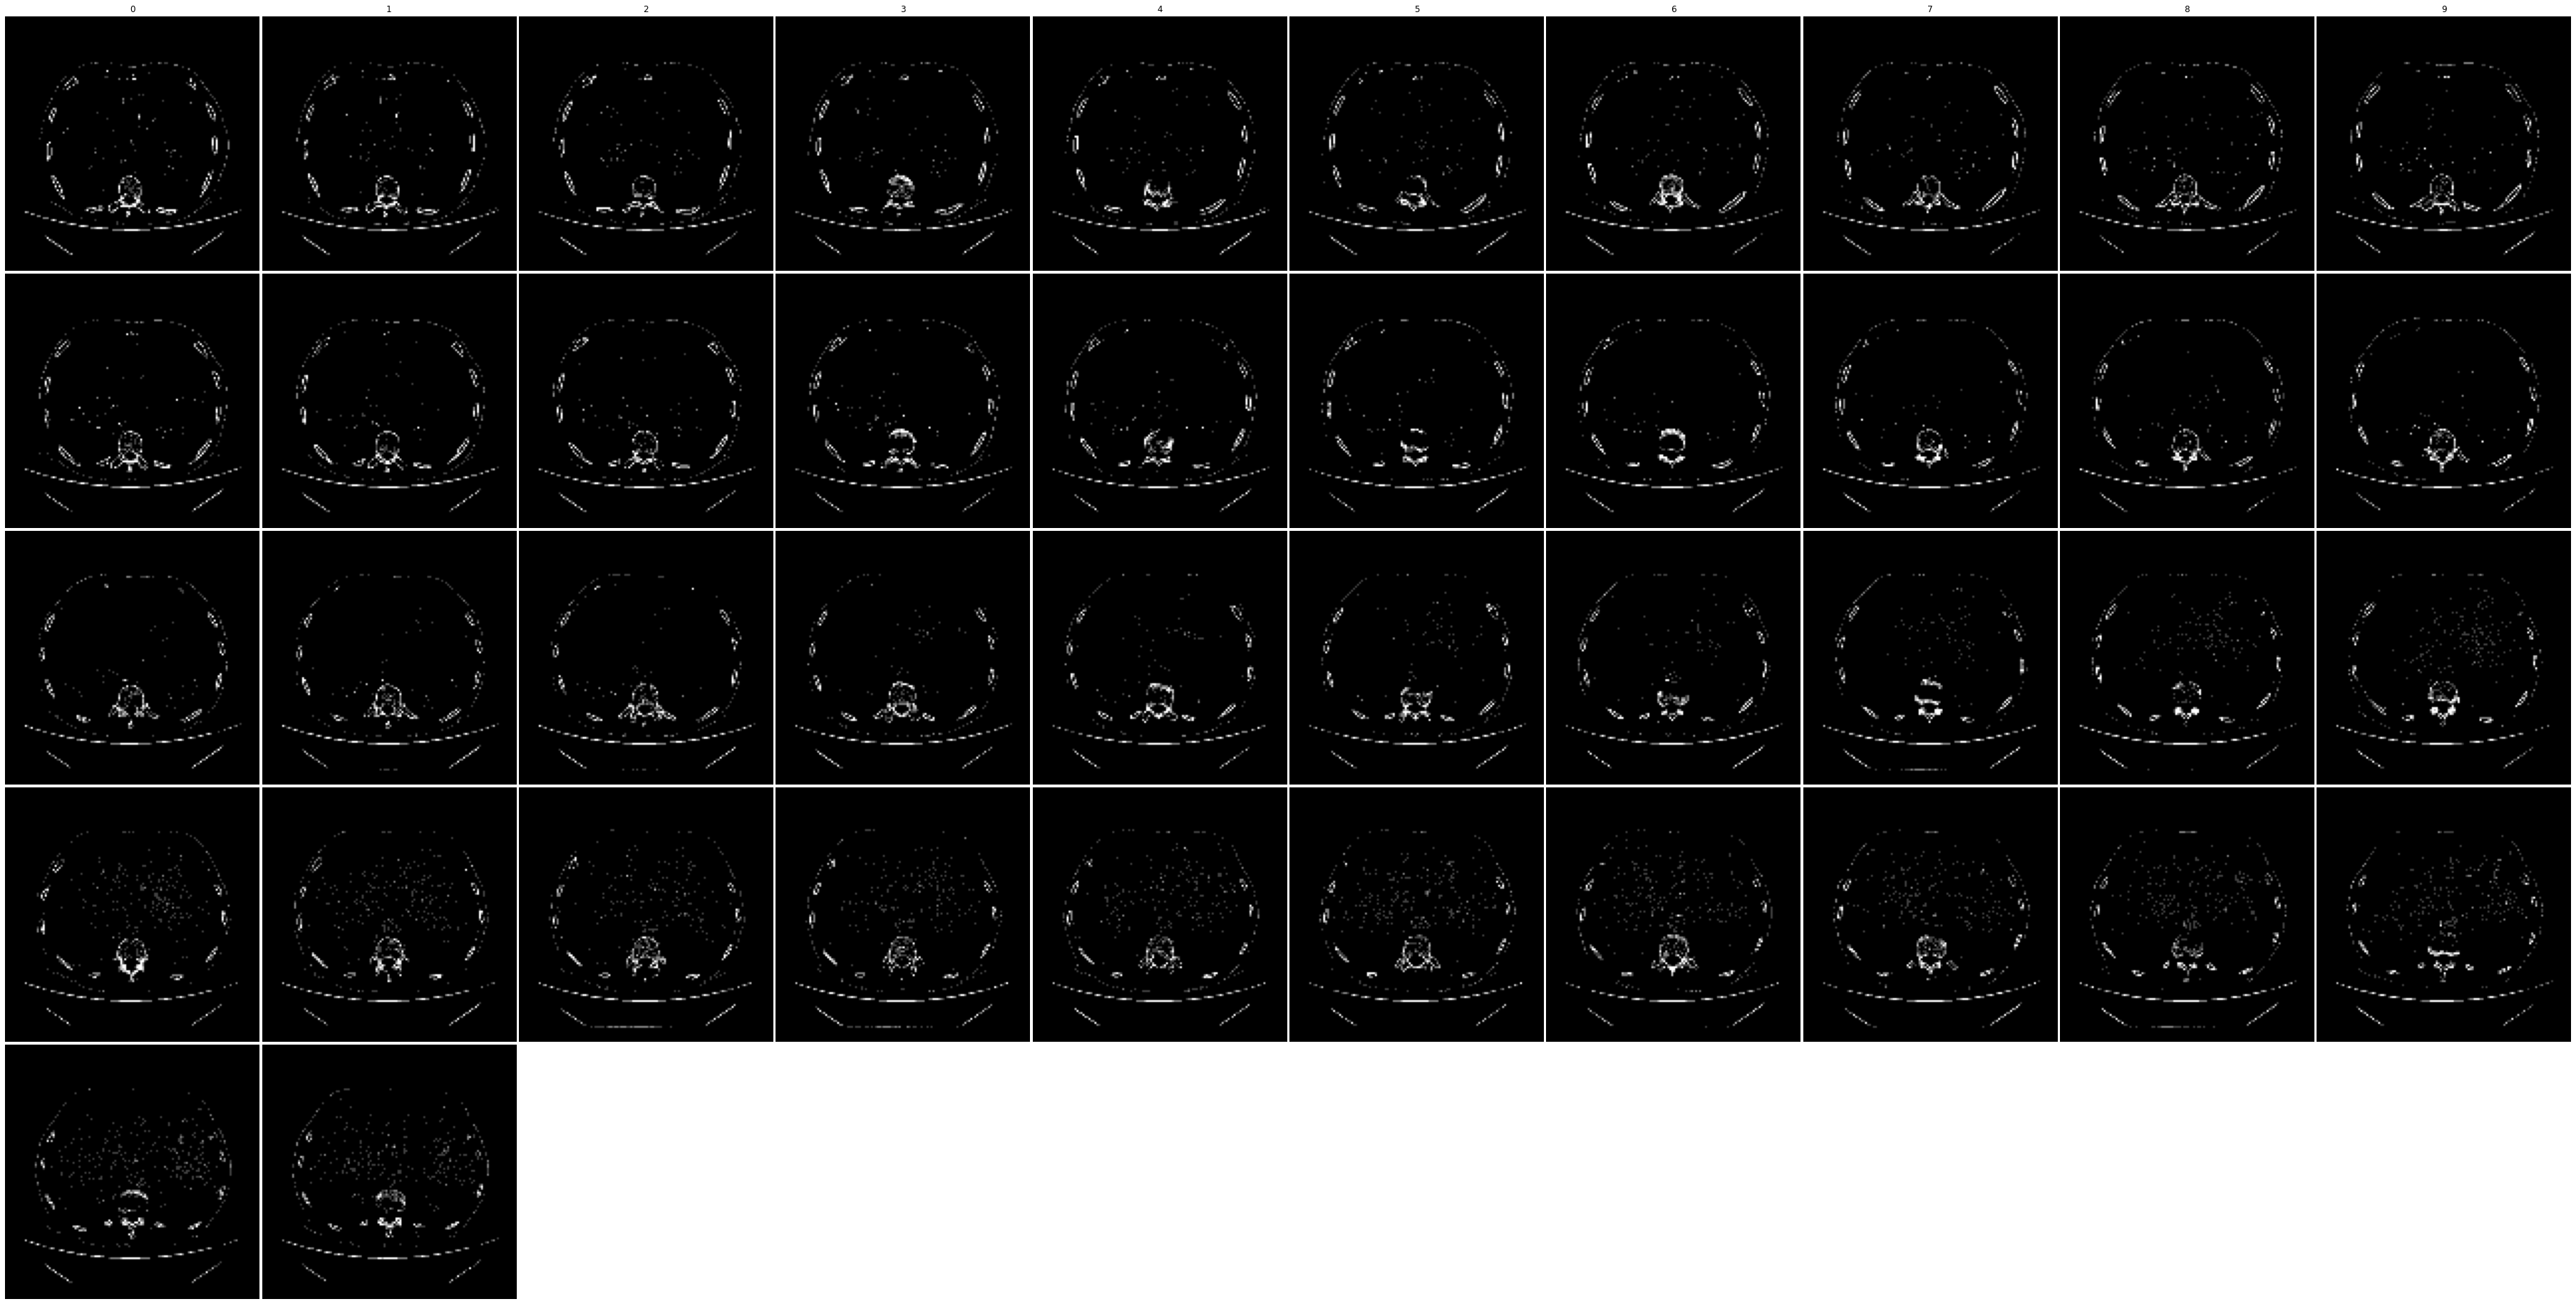

In [50]:
draw(mydata[0], columns=10)

In [54]:
!wget -q https://www.dropbox.com/sh/1j2x17k8y18k3l6/AACkAc6bCEqYVXBdODFo6Iqya/VESSEL12_ExampleScans.tar.bz2

In [55]:
!tar xf VESSEL12_ExampleScans.tar.bz2

In [56]:
!pip install SimpleITK
import SimpleITK as sitk
def read_mhd(file):
    return sitk.GetArrayFromImage(sitk.ReadImage(file, sitk.sitkFloat32))

In [60]:
vessel = read_mhd('Scans/VESSEL12_21.mhd')
vessel.shape

(459, 512, 512)

In [61]:
mask = read_mhd("Lungmasks/VESSEL12_21.mhd")
mask.shape

(459, 512, 512)

In [63]:
resized_mask = F.interpolate(torch.tensor(mask).unsqueeze(0).float(), 128, mode='bilinear').squeeze().numpy()
resized_mask.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(459, 128, 128)

In [82]:
# np.unique(resized_mask)
np.sum(resized_mask == 1)

1065866

In [67]:
first_bone = np.where(vessel > 300, 1, 0).astype('bool')
first_bone = F.interpolate(torch.tensor(first_bone).unsqueeze(0).float(), 256, mode='bilinear').squeeze().numpy()
first_bone.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(459, 256, 256)

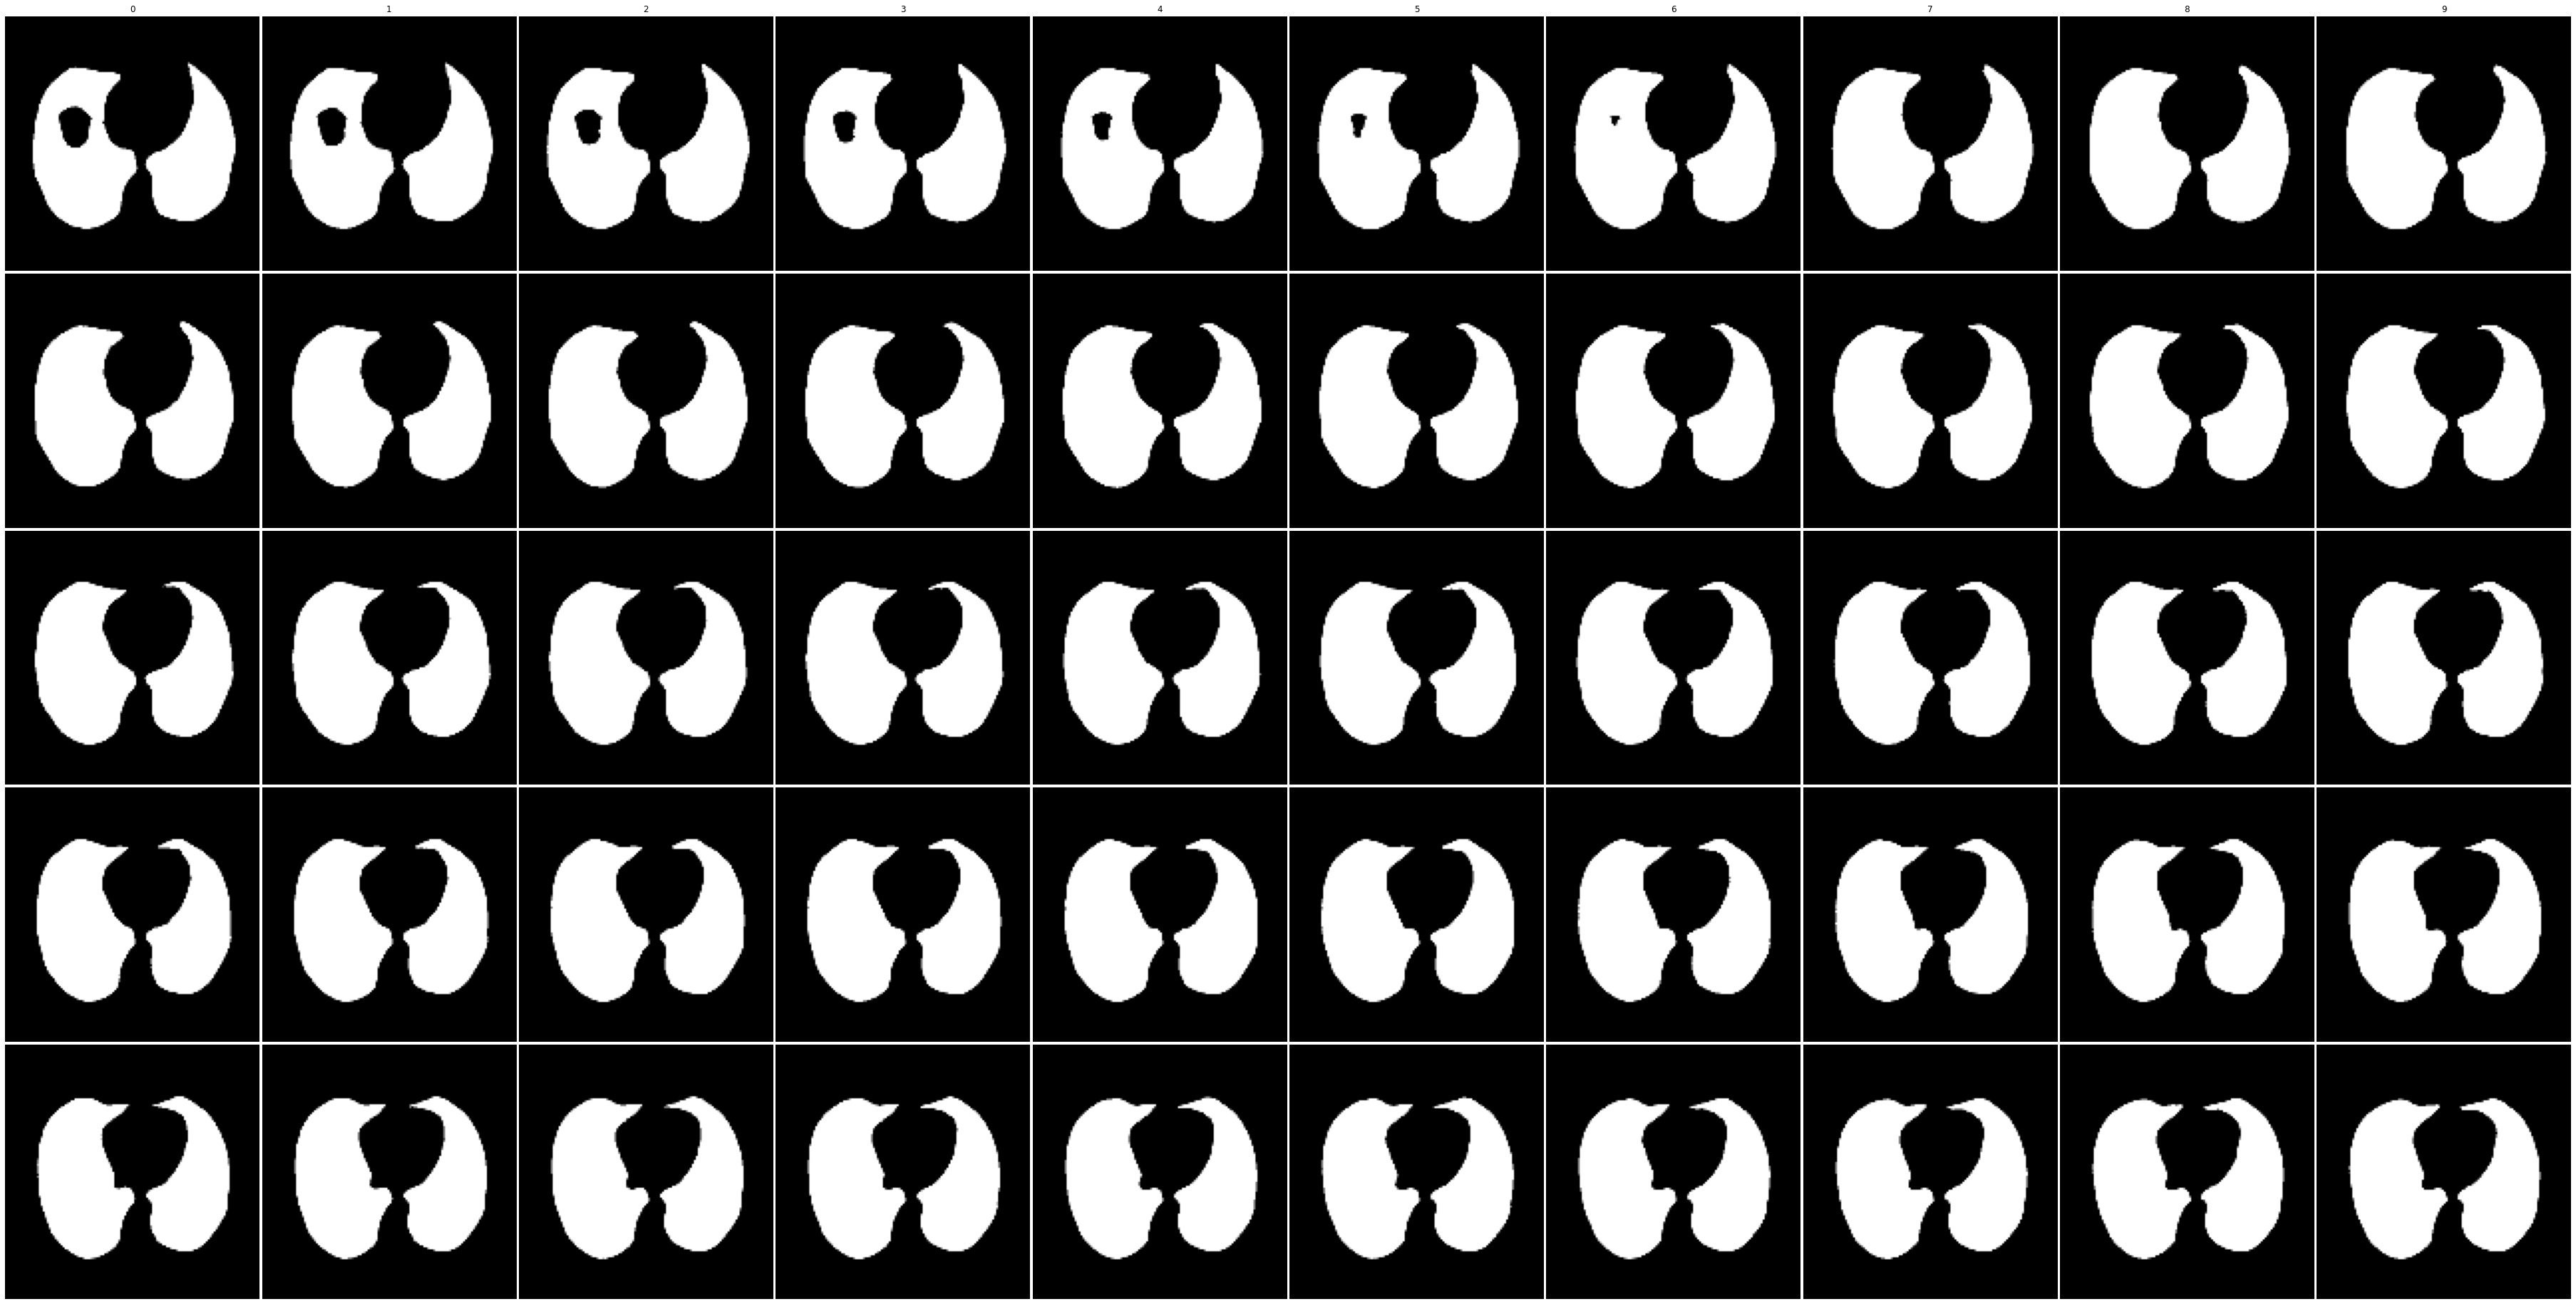

In [89]:
draw(resized_mask[150:200], columns=10)

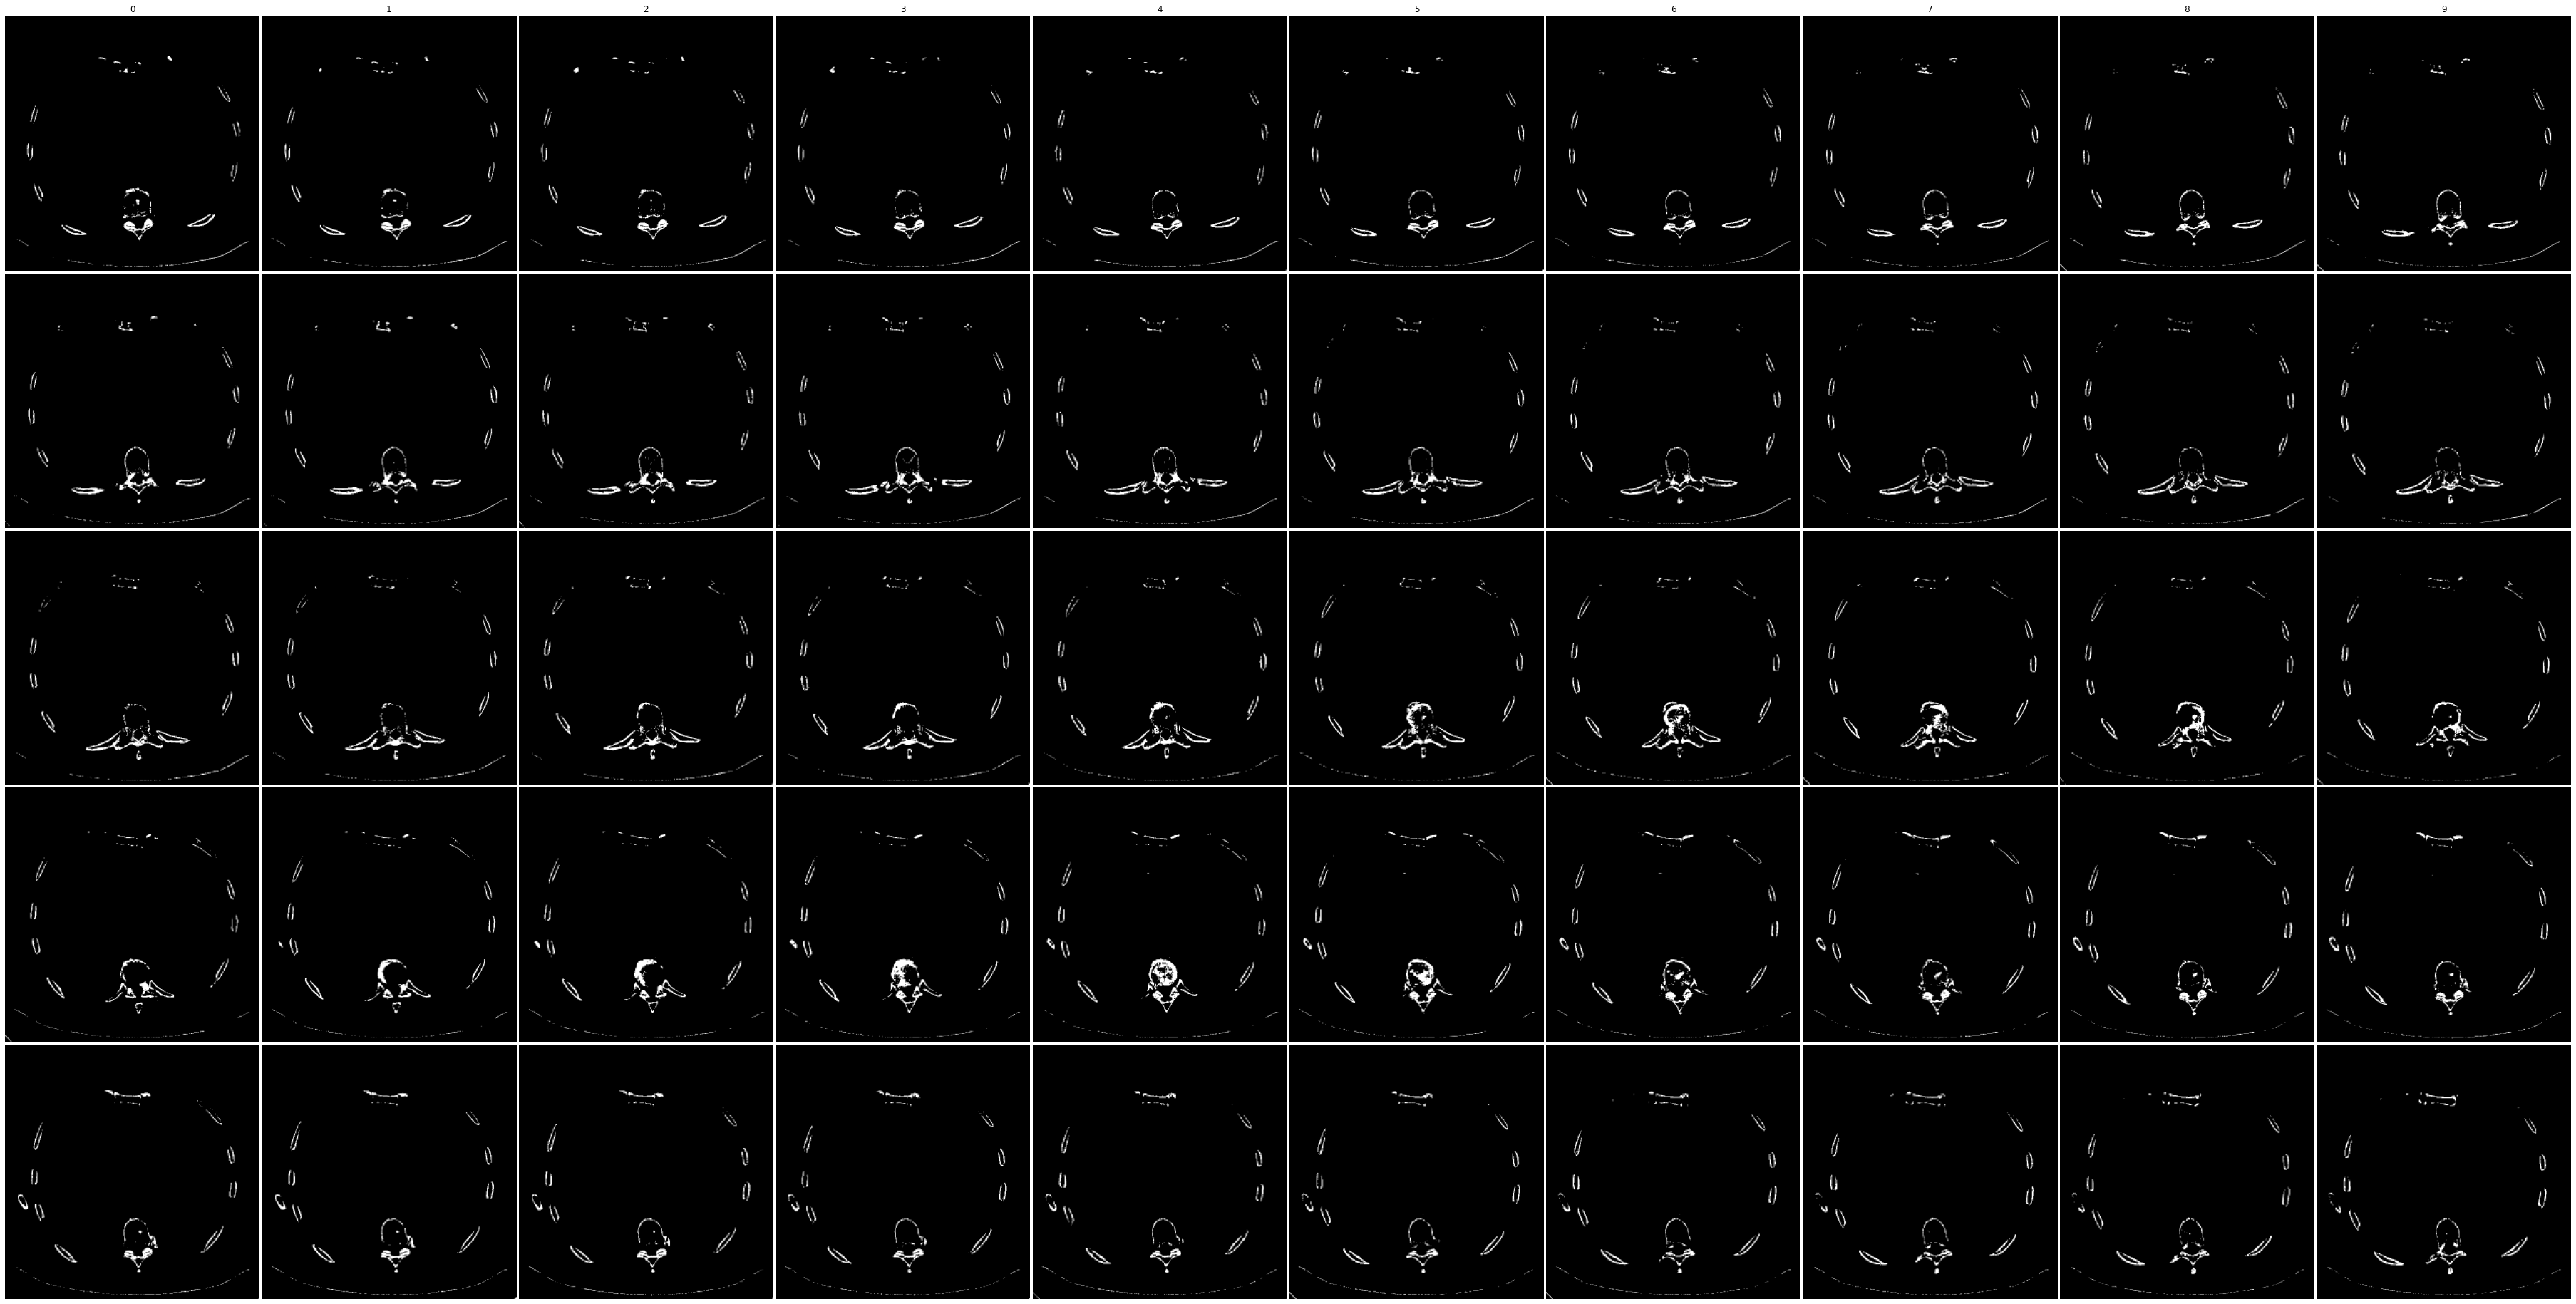

In [68]:
draw(first_bone[150:200], columns=10)

In [69]:
second_bone = F.interpolate(torch.tensor(vessel).unsqueeze(0).float(), 256, mode='bilinear').squeeze().numpy()
second_bone = np.where(second_bone > 300, 1, 0).astype('bool')
second_bone.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(459, 256, 256)

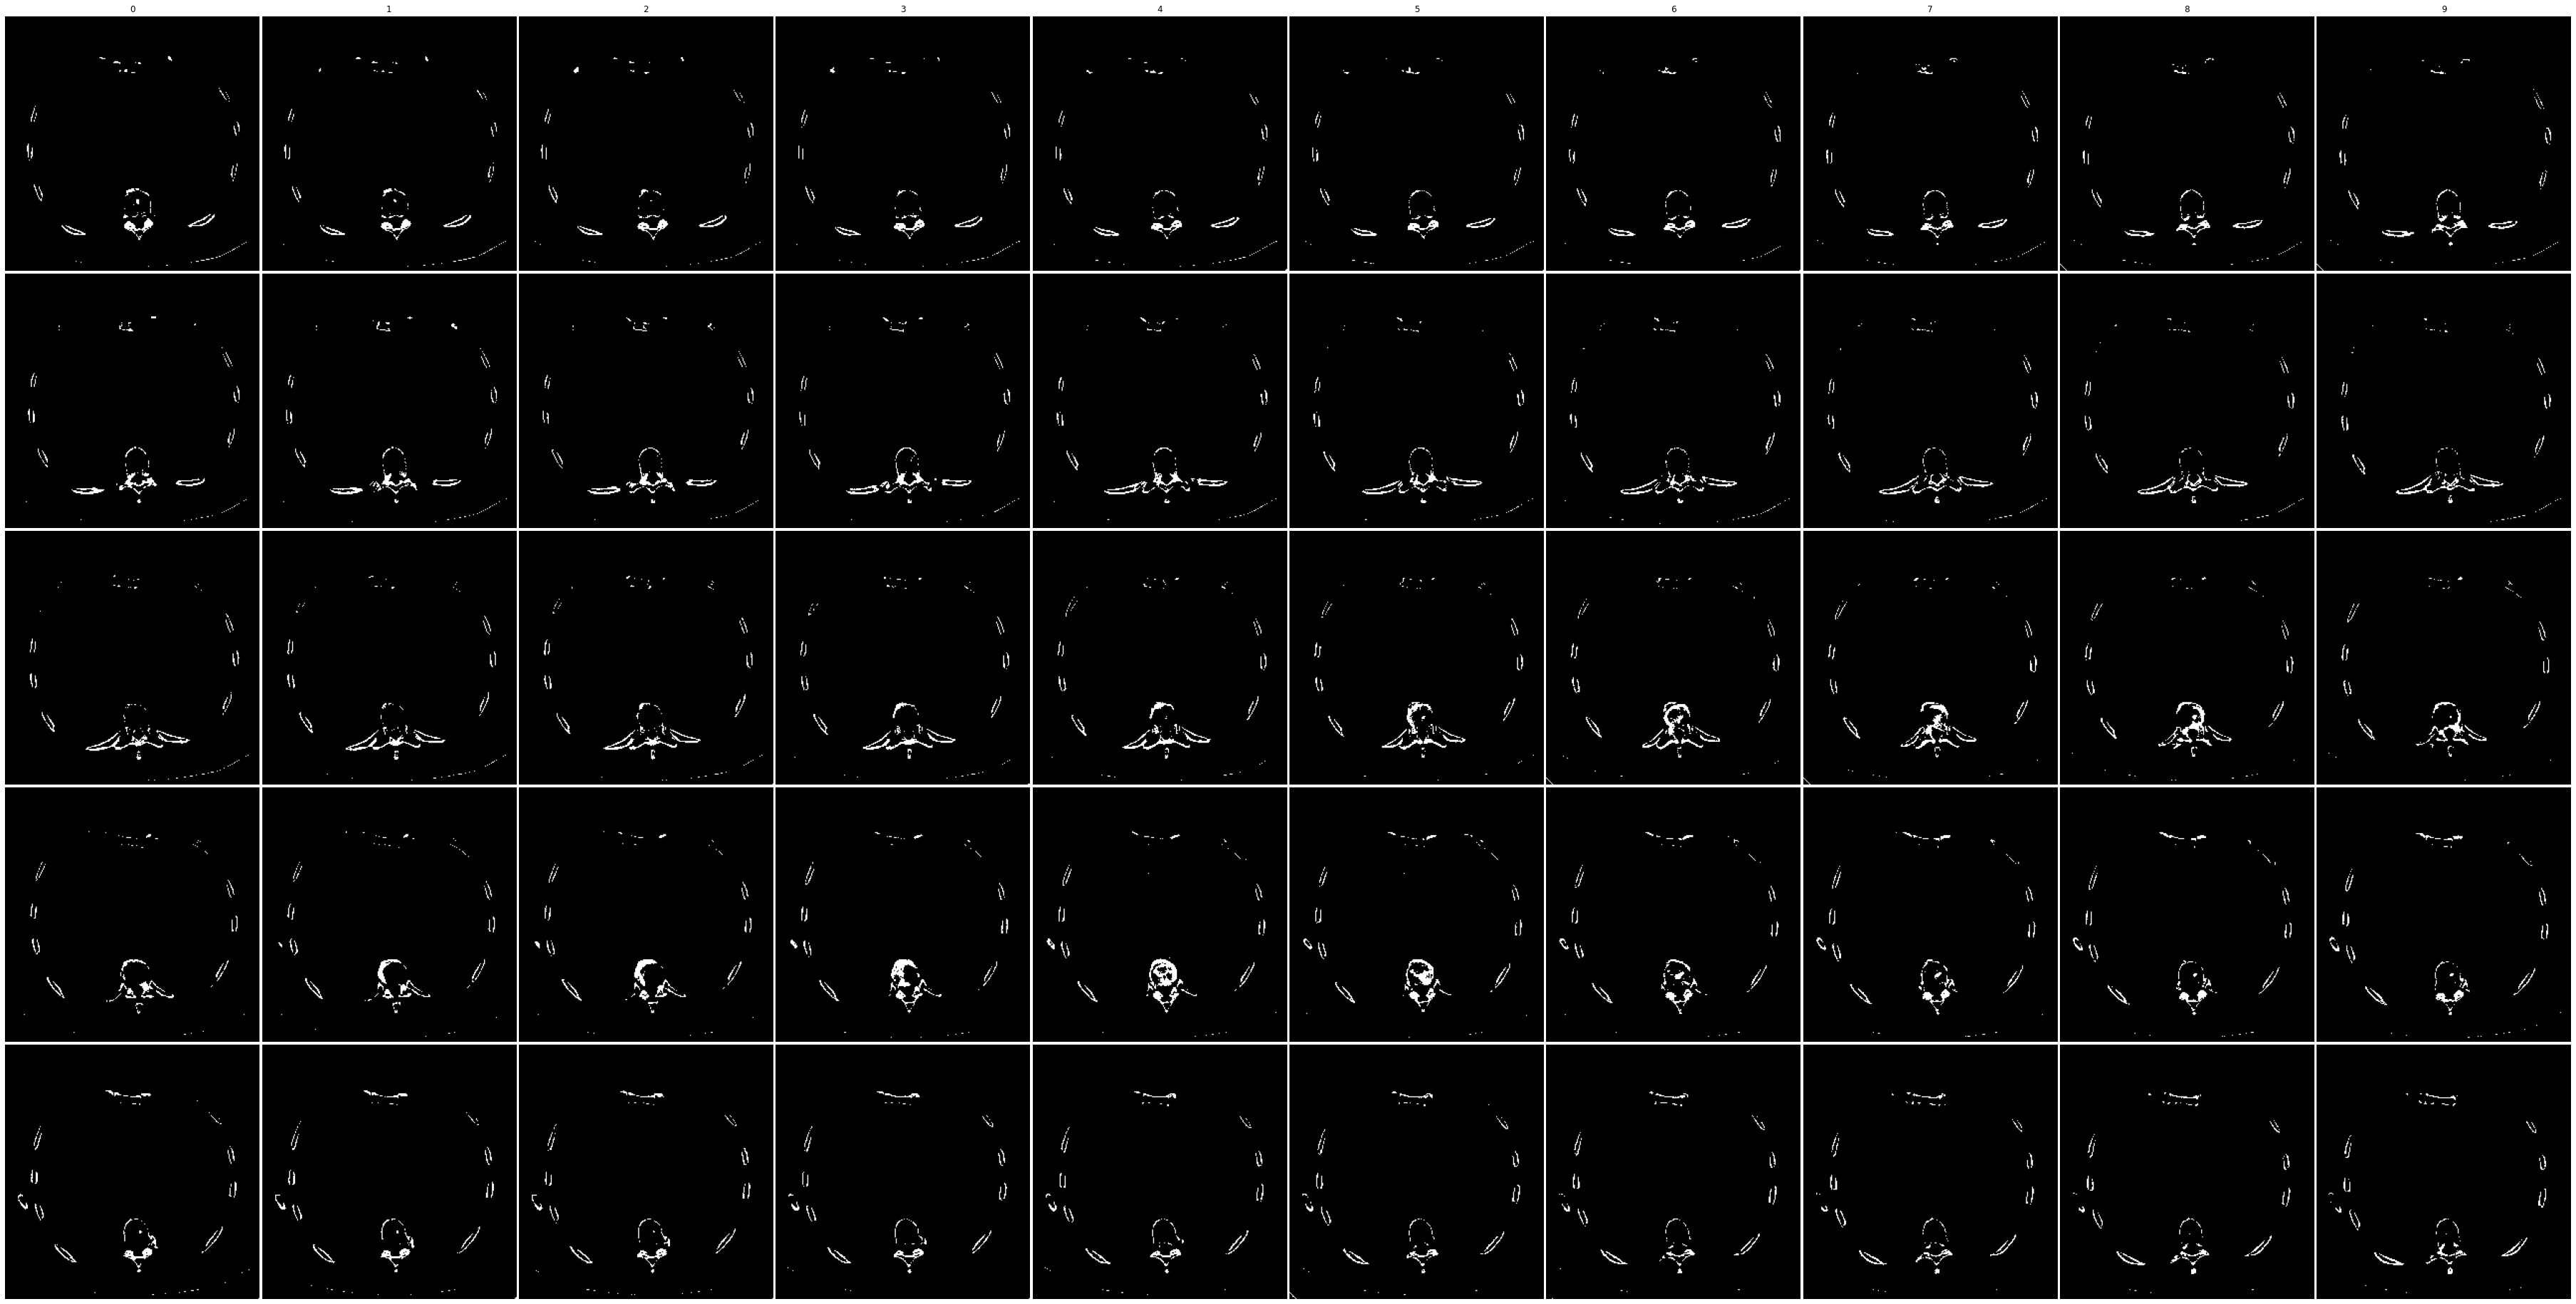

In [70]:
draw(second_bone[150:200], columns=10)